## Init

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %%capture
# !pip install -q efficientnet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle
import scipy.io
import tarfile
# import csv
# # import sys
import os
import tensorflow as tf
# import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    LearningRateScheduler,
    ModelCheckpoint,
    EarlyStopping
)
# from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
# import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split
import PIL
# from PIL import ImageOps, ImageFilter

In [ ]:
os.chdir("/content/drive/MyDrive/3_XuLyAnh_Flowers")
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1tU35xhAZwBdemxnc1j9Q3JzeU3wbyFMK/3_XuLyAnh_Flowers'

In [ ]:
EPOCHS        = 5
BATCH_SIZE    = 8
LR_step1      = 1e-3
LR_step2      = 1e-4
LR_step3      = 1e-5
VAL_SPLIT     = 0.2
CLASS_NUM     = 15       #102
IMG_SIZE      = 250       # 250    # (725*500)
IMG_CHANNELS  = 3
input_shape   = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED   = 42

## Data

### Load Data

In [ ]:
# # Đường dẫn đến tệp .tgz cần giải nén
# file_path = os.path.join(os.getcwd(), '102flowers.tgz')

# # Mở tệp .tgz
# with tarfile.open(file_path, 'r:gz') as tar:
#     # Giải nén toàn bộ nội dung của tệp .tgz vào thư mục hiện tại
#     tar.extractall()

In [ ]:
DATA_PATH = os.getcwd()
PATH = os.getcwd() + "/jpg/"

In [ ]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH + '/102flowers.tgz'))

# load file label:  label (1 -> 102) == -1 ==>  (0 -> 101)
df['Category'] = scipy.io.loadmat(DATA_PATH + '/imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype(str)

In [ ]:
top_15_categories = ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [ ]:
# Lọc DataFrame ban đầu
df_15 = df[df['Category'].isin(top_15_categories)]

In [ ]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


### Visualization Data

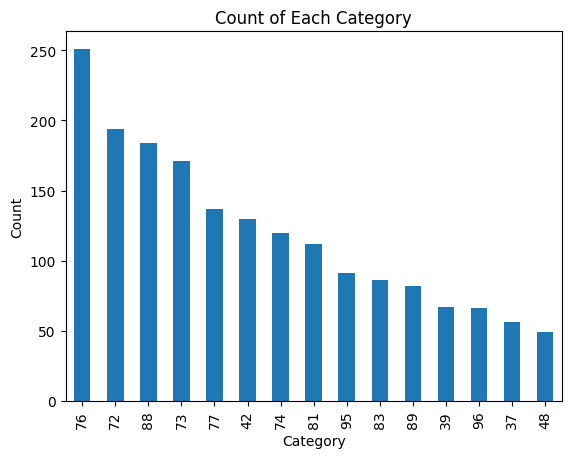

In [ ]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
df_15['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.show()

In [ ]:
# # Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
# df['Category'].value_counts().plot(kind='bar')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.title('Count of Each Category')
# plt.show()

In [ ]:
print(f"Có {df_15['Category'].nunique()} loài hoa")
print("Giá trị lớn nhất của cột 'Category':", df['Category'].value_counts().max())
print("Giá trị nhỏ nhất của cột 'Category':", df['Category'].value_counts().min())

Có 15 loài hoa
Giá trị lớn nhất của cột 'Category': 258
Giá trị nhỏ nhất của cột 'Category': 40


In [ ]:
# print(f"Có {df['Category'].nunique()} loài hoa")
# print("Giá trị lớn nhất của cột 'Category':", df['Category'].value_counts().max())
# print("Giá trị nhỏ nhất của cột 'Category':", df['Category'].value_counts().min())

In [ ]:
df_15['Category'].unique()   # giá trị từ 1 đến 101

array(['76', '72', '88', '73', '81', '77', '74', '42', '83', '89', '39',
       '37', '48', '95', '96'], dtype=object)

In [ ]:
# df['Category'].unique()   # giá trị từ 1 đến 101

In [ ]:
PATH = os.getcwd() + "/"

In [ ]:
# print('Random Sample')
# plt.figure(figsize = (12, 8))
# random_image = df_15.sample(n = 9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH + path)
#     plt.subplot(3, 3, index + 1)
#     plt.imshow(im)
#     plt.title('Class: ' + str(random_image_cat[index]))
#     plt.axis('off')

# plt.show()

In [ ]:
# print('Random Sample')
# plt.figure(figsize = (12, 8))
# random_image = df.sample(n = 9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH + path)
#     plt.subplot(3, 3, index + 1)
#     plt.imshow(im)
#     plt.title('Class: ' + str(random_image_cat[index]))
#     plt.axis('off')

# plt.show()

In [ ]:
# image = PIL.Image.open(PATH + path)
# imgplot = plt.imshow(image)
# plt.show()
# image.size

### Split Train Test

In [ ]:
train_files, test_files, train_labels, test_labels = \
    train_test_split(
        df_15['Id'],
        df_15['Category'],
        test_size = 0.2,
        random_state = 42,
        stratify = df_15['Category']
)
train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels
train_files.shape, test_files.shape

((1436, 2), (360, 2))

In [ ]:
# train_files, test_files, train_labels, test_labels = \
#     train_test_split(
#         df['Id'],
#         df['Category'],
#         test_size = 0.2,
#         random_state = 42,
#         stratify = df['Category']
# )
# train_files = pd.DataFrame(train_files)
# test_files = pd.DataFrame(test_files)
# train_files['Category'] = train_labels
# test_files['Category'] = test_labels
# train_files.shape, test_files.shape

In [ ]:
train_files.head(5)

,Id,Category
270,jpg/image_00271.jpg,72
6223,jpg/image_06224.jpg,48
263,jpg/image_00264.jpg,72
6210,jpg/image_06211.jpg,48
7678,jpg/image_07679.jpg,95


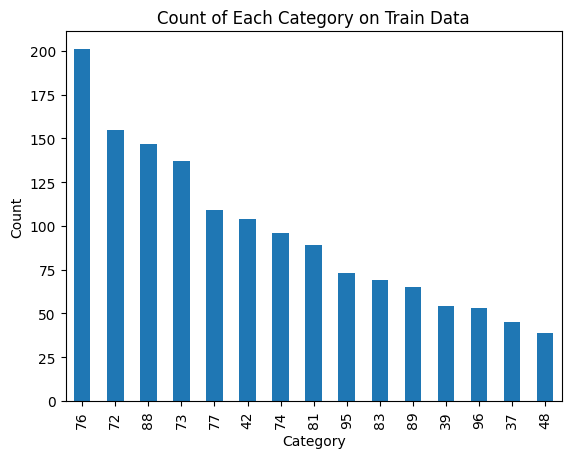

In [ ]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
train_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Train Data')
plt.show()

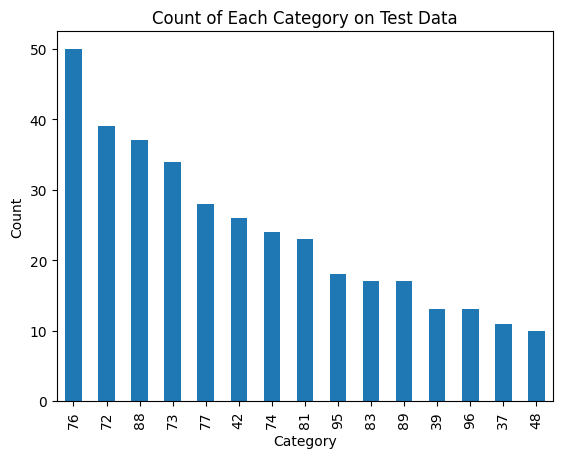

In [ ]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
test_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Test Data')
plt.show()

### Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 50,
    shear_range = 0.2,
    zoom_range = [0.75, 1.25],
    brightness_range = [0.5, 1.5],
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = RANDOM_SEED
)

Found 1436 validated image filenames belonging to 15 classes.
Found 360 validated image filenames belonging to 15 classes.


In [ ]:
train_generator.samples

1436

Ví dụ về hình ảnh từ train_generator


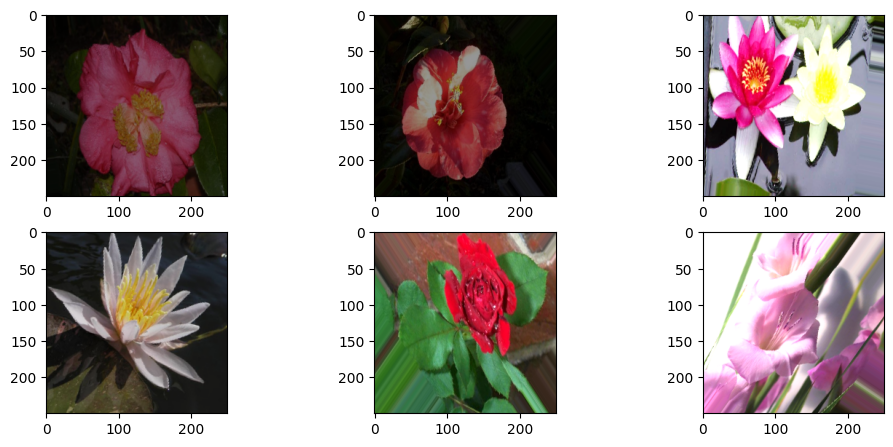

In [ ]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x, y = train_generator.next()
print('Ví dụ về hình ảnh từ train_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

Ví dụ về hình ảnh từ test_generator


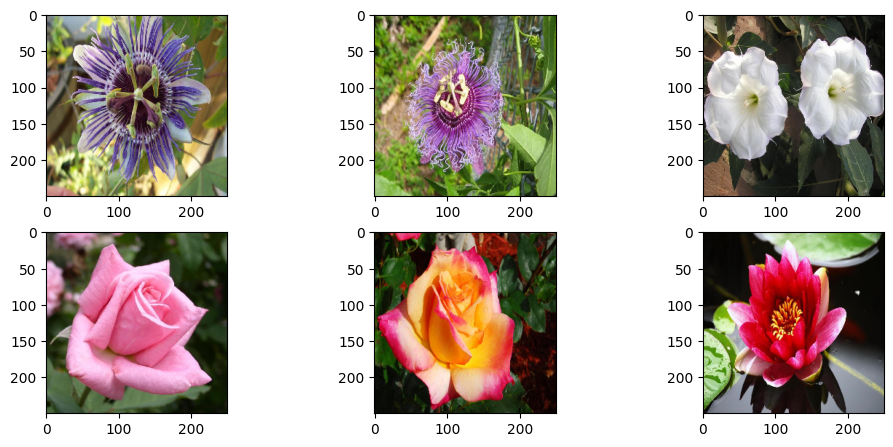

In [ ]:
x, y = test_generator.next()
print('Ví dụ về hình ảnh từ test_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

## Model AlexNet

### AlexNet

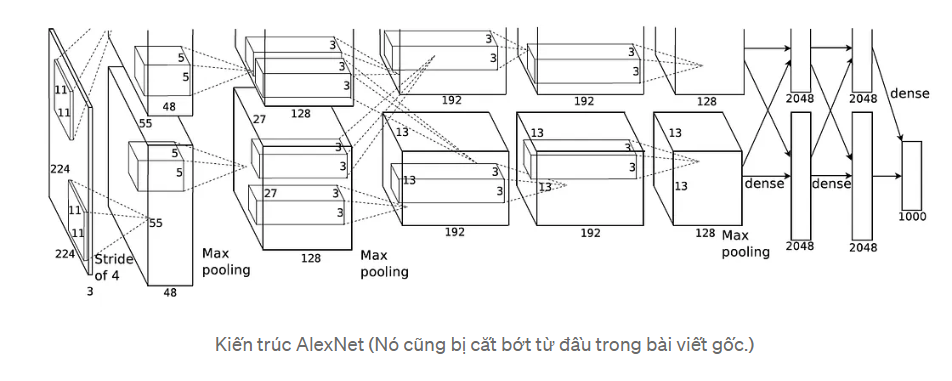

In [ ]:
# L.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu')
# # old
# model_alexnet = M.Sequential()
# model_alexnet.add(L.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape))
# model_alexnet.add(L.Conv2D(96, (11, 11), strides=(4, 4), padding='same', activation='relu'))
# model_alexnet.add(L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
# model_alexnet.add(L.Conv2D(256, (5, 5), strides=(2, 2), padding='same', activation='relu'))
# model_alexnet.add(L.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
# model_alexnet.add(L.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# model_alexnet.add(L.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# model_alexnet.add(L.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# model_alexnet.add(L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
# model_alexnet.add(L.Flatten())
# model_alexnet.add(L.Dense(2048, activation='relu'))
# model_alexnet.add(L.Dense(2048, activation='relu'))
# # model_alexnet.add(L.Dense(10, activation='softmax'))
# model_alexnet.summary()

In [ ]:
NUM_CLASSES = 15

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout


model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(NUM_CLASSES,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 27, 27, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 256)       0         
 g2D)                                                            
                                                        

In [ ]:
print(len(model.layers))
print(len(model.trainable_variables))

22
30


In [ ]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79eeb80d8190> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79eebde5eb90> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x79eeb97b1f00> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79eeb97b1ed0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79eeb97b2500> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x79eeb97b2a10> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79eeb97b1cf0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79eeb97b3b50> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79eeb29c9fc0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79eeb29cb0d0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x79eeb29cb100> True
<keras.src.layers.reshaping.flatten.Flatten object at 0x7

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

### Huấn luyện

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint = load_model(
#     '/content/drive/MyDrive/3_XuLyAnh_Flowers/SaveModel/alexnet_cuong4_step1.keras',

#     monitor='val_accuracy',
#     verbose=1,
#     mode='max',
#     save_best_only=True,  # Chỉ lưu checkpoint tốt nhất
#     save_weights_only=False,  # Lưu toàn bộ mô hình, không chỉ trọng số
#     save_freq=20  # Lưu checkpoint mỗi 20 epochs
# )

# earlystop = EarlyStopping(
#     monitor='val_accuracy',
#     patience=500,
#     restore_best_weights=True
# )

# callbacks_list = [checkpoint, earlystop]


ValueError: The following argument(s) are not supported with the native Keras format: ['monitor', 'verbose', 'mode', 'save_best_only', 'save_weights_only', 'save_freq']

In [ ]:
from tensorflow.keras.models import load_model

# Đường dẫn đến checkpoint đã lưu
checkpoint_path = '/content/drive/MyDrive/3_XuLyAnh_Flowers/SaveModel/alexnet_cuong4_step1.hdf5'

# Load mô hình từ checkpoint
loaded_model = load_model(checkpoint_path)

# Compile lại mô hình sau khi đã load checkpoint
# loaded_model.compile(
#     loss='categorical_crossentropy',
#     optimizer=optimizers.Adam(learning_rate=LR_step1),
#     metrics=['accuracy']
# )

# Tiếp tục huấn luyện từ checkpoint đã load
history = loaded_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=150,  # Số lần lặp lại (epochs) có thể điều chỉnh tùy thuộc vào dữ liệu và mô hình của bạn
    callbacks=callbacks_list  # Bạn có thể thêm callback đã định nghĩa trước đó nếu cần thiết
)


Epoch 1/150
 19/179 [==>...........................] - ETA: 4:02 - loss: 3.5680 - accuracy: 0.1053

 39/179 [=====>........................] - ETA: 3:02 - loss: 3.5630 - accuracy: 0.1186

 58/179 [========>.....................] - ETA: 2:41 - loss: 3.4266 - accuracy: 0.1250

In [ ]:
model.save('./SaveModel/alexnet_cuong5_step1.hdf5')
# model.load_weights('best_model_test_2.hdf5')

In [ ]:
model.save('./SaveModel/alexnet_cuong5_step1.keras')
# model.load_weights('best_model_test_2.hdf5')

## Cur

In [ ]:
# # scores = model.evaluate_generator(test_generator, verbose = 1)
# scores = model.evaluate(test_generator, verbose=1)
# print('Accuracy: %.2f%%' % (scores[1] * 100))

In [ ]:
train_generator

In [ ]:
def plot_history(history):
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label = 'Training acc')
    plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
#     plt.figure()
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)

## this

In [ ]:
predictions = model.predict(test_generator, verbose = 1)
predictions = np.argmax(predictions, axis = -1)         # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k, v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir = test_generator.filenames
submission = pd.DataFrame(
    {'Predict': predictions},
    columns = ['Predict'],
    index = filenames_with_dir
)
test_files.index = test_files['Id']
tmp_y = pd.concat(
    [submission['Predict'], test_files['Category']],
    axis = 1,
    sort = False
)
tmp_y.head(5)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f%%' % (
    accuracy_score(tmp_y['Category'], tmp_y['Predict']) * 100
))

### confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# tmp_y['Category'] là nhãn thực tế, tmp_y['Predict'] là dự đoán của mô hình
conf_matrix = confusion_matrix(tmp_y['Category'], tmp_y['Predict'])

print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Vẽ heatmap cho confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# In ra các trường hợp nhầm lẫn
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j and conf_matrix[i][j] > 0:
            print("Thực tế:", i, "Dự đoán:", j, "Số lượng:", conf_matrix[i][j])

In [ ]:
# Tính tổng số lượng nhầm lẫn cho từng loại
errors_per_category = conf_matrix.sum(axis=1)

# Xây dựng bảng thống kê
error_table = []
for i, error_count in enumerate(errors_per_category):
    error_table.append({'Loại': i, 'Số lượng nhầm lẫn': error_count})

# Sắp xếp bảng thống kê theo số lượng nhầm lẫn giảm dần
error_table.sort(key=lambda x: x['Số lượng nhầm lẫn'], reverse=True)

# In bảng thống kê
print("Bảng thống kê số loại bị nhầm lẫn nhiều nhất từ cao đến thấp:")
for item in error_table:
    print("Loại:", item['Loại'], "- Số lượng nhầm lẫn:", item['Số lượng nhầm lẫn'])

In [ ]:
# Lấy thông tin để vẽ biểu đồ
categories = [str(item['Loại']) for item in error_table[0:15]]
errors = [item['Số lượng nhầm lẫn'] for item in error_table[0:15]]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(categories, errors, color='skyblue')
plt.xlabel('Loại')
plt.ylabel('Số lượng nhầm lẫn')
plt.title('Số lượng loại bị nhầm lẫn nhiều nhất từ cao đến thấp cho từng loại')
plt.xticks(categories)
plt.show()


Category: ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [ ]:
print(categories)

Đây là các 15 loại nhầm lẫn nhiều nhất.
Công việc tiếp theo:
- Tính ra % chính xác của model efficientnetB6 với 15 loại này (dự đoán sẽ giảm so với 84% trên toàn bộ tập dữ liệu)
- Cắt bộ dữ liệu ra 15 loại
- Huấn luyện trên model Lenet5 với 37tr tham số, Alexnet, GoogleNet và thống kê kết quả

tính độ chính xác của 15 loại trên best model efficientNetB6:
- phải huấn luyện lại mô hình trên 15 loại này
- rồi đánh giá lại, mà huấn luyện rất mất thời gian, chắc là dùng lại model hiện giờ luôn.